In [322]:
import os
import torch
import clip
import hnswlib
import numpy as np
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress tracking

# Load CLIP model and set device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model, preprocess = clip.load("ViT-L/14", device=device)

SIMILARITY_CUTOFF = 0.25  # Reasonable threshold to filter low similarity results
IMAGES_PER_ROW = 5

In [302]:
def get_image_embeddings(image_paths):
    """
    Extracts CLIP embeddings for a list of images.
    """
    all_embeddings = []
    batch_size = 32  # Adjust based on memory availability
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Embedding Images"):
        batch_paths = image_paths[i:i+batch_size]
        images = [preprocess(Image.open(img_path)).unsqueeze(0) for img_path in batch_paths]
        image_inputs = torch.cat(images).to(device)
        
        with torch.no_grad():
            features = model.encode_image(image_inputs)
            features = features / features.norm(dim=-1, keepdim=True)  # Normalize
            
        all_embeddings.append(features.cpu().numpy())
    
    return np.vstack(all_embeddings)  # Stack all batches into a single array

def get_text_embedding(text_query):
    """
    Extracts CLIP embedding for a text query.
    """
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize([text_query]).to(device))
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # Normalize
    return text_features.cpu().numpy()[0]  # Convert to NumPy 1D array


In [303]:
def cosine_search(image_embeddings, text_embedding, top_k=1):
    """
    Finds the top-k most similar images using cosine similarity.
    """
    similarities = np.dot(image_embeddings, text_embedding)  # Faster than sklearn cosine_similarity
    top_matches = np.argsort(similarities)[-top_k:][::-1]  # Get top-k matches
    return top_matches, similarities[top_matches]


def hnsw_search(image_embeddings, text_embedding, top_k=1):
    """
    Finds the top-k most similar images using HNSW graph search.
    """
    dim = image_embeddings.shape[1]
    num_elements = image_embeddings.shape[0]
    
    hnsw_index = hnswlib.Index(space='cosine', dim=dim)
    hnsw_index.init_index(max_elements=num_elements, ef_construction=200, M=32)
    hnsw_index.add_items(image_embeddings, np.arange(num_elements))
    hnsw_index.set_ef(100)  # Increase search quality
    
    labels, _ = hnsw_index.knn_query(text_embedding, k=top_k)
    return labels[0]

def correct_image_orientation(img):
    """
    Corrects the image orientation using EXIF data if available.
    """
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = img._getexif()
        if exif is not None and orientation in exif:
            if exif[orientation] == 3:
                img = img.rotate(180, expand=True)
            elif exif[orientation] == 6:
                img = img.rotate(270, expand=True)
            elif exif[orientation] == 8:
                img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        pass  # Image has no EXIF data or orientation tag
    return img


def show_images(image_paths, indices, similarities, title="Top Matching Images"):
    """
    Displays images in a gallery layout with a max of IMAGES_PER_ROW per row.
    """
    num_images = len(indices)
    num_rows = (num_images + IMAGES_PER_ROW - 1) // IMAGES_PER_ROW  # Calculate needed rows
    fig, axes = plt.subplots(num_rows, IMAGES_PER_ROW, figsize=(5 * IMAGES_PER_ROW, 5 * num_rows))
    axes = np.array(axes).reshape(-1)  # Flatten axes array for easy iteration
    
    for ax, idx, sim in zip(axes[:num_images], indices, similarities):
        img = Image.open(image_paths[idx])
        img = correct_image_orientation(img)  # Correct orientation
        ax.imshow(img)
        ax.set_title(f"Sim: {sim:.4f}")  # Display similarity score
        ax.axis("off")
    
    # Hide unused subplots
    for ax in axes[num_images:]:
        ax.axis("off")
    
    plt.suptitle(title)
    plt.show()

In [323]:
# Example usage
print(f"Device in use: {device}")
# image_dir = "/Users/adityapatil/Pictures/Kuari Pass 2"
image_dir = "/Users/adityapatil/photos_backup"

image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.lower().endswith((".jpg", ".png", ".jpeg"))][:1000]
print(len(image_paths))
# Generate embeddings
image_embeddings = get_image_embeddings(image_paths)

Device in use: mps
1000


Embedding Images: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [02:45<00:00,  5.19s/it]


In [358]:

query = "Photos of tortoise in a pond"
# query = "a photo of evening orange glow over a snow capped mountain peak"
text_embedding = get_text_embedding(query)


No image with the description found.
Would you be interested in seeing other remotely similar images?
Filtered Matches Above Similarity Cutoff:
/Users/adityapatil/photos_backup/IMG_1479.JPG - Similarity: 0.1951
/Users/adityapatil/photos_backup/IMG_1478.JPG - Similarity: 0.1848


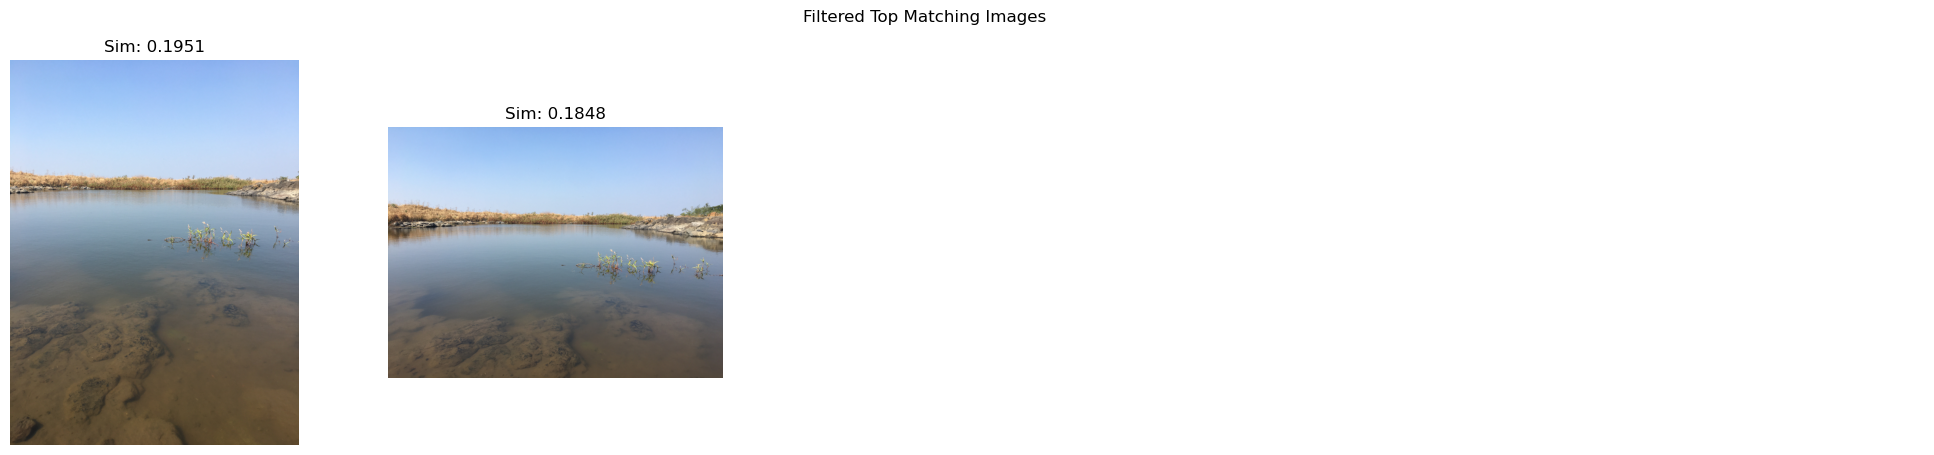

Best Image Embedding: [-0.02449  -0.01396   0.01732  -0.0662   -0.02896  -0.0219    0.01027
  0.00542   0.003595  0.006992]
Text Embedding: [-0.01723  -0.00492   0.01656  -0.01695  -0.04865   0.001928  0.03995
 -0.03735  -0.04193   0.00499 ]


In [360]:
top_k = 10


# Measure Cosine Search Time
start_time = time.time()
cosine_matches, cosine_similarities = cosine_search(image_embeddings, text_embedding, top_k=top_k)
cosine_time = time.time() - start_time

# Measure HNSW Search Time
# start_time = time.time()
# hnsw_matches = hnsw_search(image_embeddings, text_embedding, top_k=top_k)
# hnsw_time = time.time() - start_time

# Apply similarity cutoff
top_m_indices = [idx for idx, sim in zip(cosine_matches, cosine_similarities) if sim >= SIMILARITY_CUTOFF]
top_m_similarities = [sim for sim in cosine_similarities if sim >= SIMILARITY_CUTOFF]

if len(top_m_indices) == 0:
    print("No image with the description found.")
    print("Would you be interested in seeing other remotely similar images?")
    top_m_indices = cosine_matches[:2]  # Show the top 2 best matches regardless of score
    top_m_similarities = cosine_similarities[:2]

# Print results
print(f"Filtered Matches Above Similarity Cutoff:")
for idx, sim in zip(top_m_indices, top_m_similarities):
    print(f"{image_paths[idx]} - Similarity: {sim:.4f}")


# Show filtered images as a collage with similarity scores
show_images(image_paths, top_m_indices, top_m_similarities, title="Filtered Top Matching Images")



# Print results
# print(f"Top {top_k} Cosine Similarity Matches: {[image_paths[i] for i in cosine_matches]} (Time: {cosine_time:.6f} sec)")
# print(f"Top {top_k} HNSW Matches: {[image_paths[i] for i in hnsw_matches]} (Time: {hnsw_time:.6f} sec)")

# Print embeddings
print("Best Image Embedding:", image_embeddings[cosine_matches[0]][:10])
print("Text Embedding:", text_embedding[:20])

# Show top-k images as a collage
# show_images(image_paths, cosine_matches, cosine_similarities, title="Top Cosine Similarity Matches")

In [ ]:
query = "Photos of tortoise in a pond"
# query = "a photo of evening orange glow over a snow capped mountain peak"
text_embedding = get_text_embedding(query)

# Testing chromadb

In [34]:
import chromadb

In [35]:
client = chromadb.PersistentClient(path="")
image_loader = ImageLoader()
multimodal_ef = OpenCLIPEmbeddingFunction()
collection = client.get_or_create_collection(
    name=index_name,
    embedding_function=multimodal_ef,
    data_loader=image_loader,
    metadata={"hnsw:space": "cosine"}
)


NameError: name 'vectordb' is not defined

In [378]:

query1 = "Thor"
query2 = "Hammer"
query3 = "Mjolnir"

# query = "a photo of evening orange glow over a snow capped mountain peak"
text_embedding1 = get_text_embedding(query1)
text_embedding2 = get_text_embedding(query2)
text_embedding3 = get_text_embedding(query3)

text_embedding4 = text_embedding1 + text_embedding2

In [379]:
print(text_embedding1[:15])
print(text_embedding2[:15])
print(text_embedding3[:15])
print(text_embedding4[:15])

[ 1.9913e-03  1.2535e-02  3.5736e-02 -2.6627e-02 -7.5836e-03 -5.7068e-03
 -1.5411e-02 -1.7899e-02 -2.4628e-02 -3.1830e-02  4.2610e-03 -1.8060e-05
 -1.1778e-03  5.7037e-02 -2.0905e-02]
[-0.02051    -0.02068     0.04306    -0.02937     0.002071   -0.00011176
 -0.003044   -0.03017    -0.007835   -0.0194     -0.015114   -0.009
 -0.01729     0.02603    -0.01235   ]
[-0.01775  -0.01904   0.0372   -0.00868  -0.01605  -0.0204   -0.01481
 -0.02795  -0.02734  -0.03842  -0.008736 -0.01119   0.002653  0.03345
  0.004845]
[-0.01852  -0.00814   0.0788   -0.056    -0.005512 -0.005817 -0.01846
 -0.04807  -0.03247  -0.0512   -0.01085  -0.00902  -0.01846   0.08307
 -0.03326 ]


In [380]:
# similarity11 = np.dot(text_embedding1, text_embedding1)
similarity12 = np.dot(text_embedding1, text_embedding2)/np.linalg.norm(text_embedding1)/np.linalg.norm(text_embedding2)
similarity34 = np.dot(text_embedding3, text_embedding4)/np.linalg.norm(text_embedding3)/np.linalg.norm(text_embedding4)
similarity13 = np.dot(text_embedding1, text_embedding3)/np.linalg.norm(text_embedding1)/np.linalg.norm(text_embedding3)
similarity23 = np.dot(text_embedding2, text_embedding3)/np.linalg.norm(text_embedding2)/np.linalg.norm(text_embedding3)
# similarity1 = np.dot(image_embeddings, text_embedding)

print(similarity12)
print(similarity13)
print(similarity23)
print(similarity34)

0.832
0.7954
0.8423
0.855


In [377]:
A dot B = ABcos(theta)

SyntaxError: invalid syntax (782308118.py, line 1)